<a href="https://colab.research.google.com/github/VVillT/AI-For-Beginners/blob/main/PDF_Documents_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Use Case: Parsing Documents with AI

(This example is taken from the book [AI-Powered  Business Intelligence](https://www.aipoweredbi.com/))

## Overview
1. Problem Statement
2. Solution Overview
3. Preparations
4. Call AI Service
5. Transform AI outputs
6. Export flat table
7. Vizualisation in BI

##1. Problem Statement

Imagine we're working for a German consulting company. Sales representatives travel frequently to potential customers to prepare or close deals. The travel is mostly done via high-speed trains that connect the big cities of Germany, called InterCity Express (ICE).

Our travel management department keeps control of the overall expenses. The process for business travel is as follows: 

* Sales reps can book their train tickets over a self-service portal from the train operator (Deutsche Bahn). 
* These tickets are paid for with a company credit card. 
* The travel management team oversees the credit card billing at the end of each month to get an overview of the travel expenses. 
* However, the credit card statements do not provide any further detail except for the amount spent and the date. 

To optimize travel expenses and better understand which business trips are causing the most costs, the **travel management team wants more insights about the trips, including a breakdown by popular travel routes (train origin and train destinations)**.

This information can be found in the booking receipt that the sales representatives automatically receive via email after every successful booking (see below)

In particular, the team is interested in extracting the following information from this form: 
* booking date, 
* trip origin, 
* trip destination, 
* ticket price. 

The travel management team wants to find out if there is a way to extract this information automatically and ideally report it using the existing BI. 

They have provided us with a sample of 162 receipts from a single sales representative to work on a first prototype.

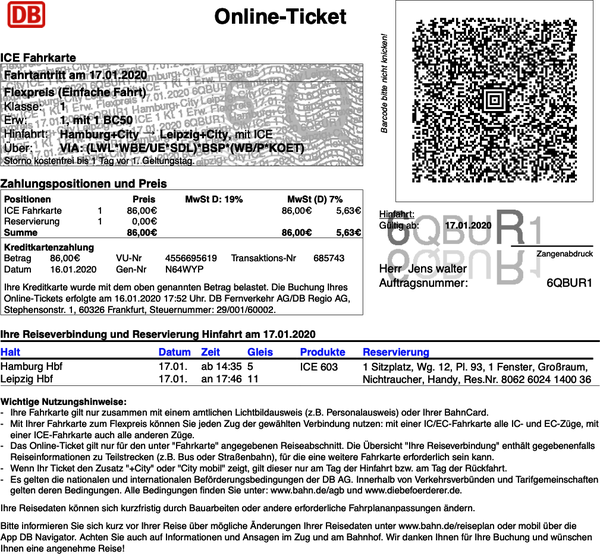

##2. Solution Overview

In this scenario, we’re going to extract information from a document using optical character recognition (OCR).

AI will help us with at least two ways. 

1. Improve the actual OCR—that is, recognizing single text characters and converting them into machine-readable form (plain-text string). 

2. Making sense of the characters, to find out which ones belong to a word or a sentence, or even recognizing more complex structures like tables.

The use case architecture is as follows:

1. Deploy an out-of-the box AI service on Microsoft Azure—in this case, Cognitive Services for Computer Vision (analysis layer).

2. Load the data into a staging area—in this case, again using Azure Blob Storage (data layer).

3. Prepare a small ETL script that loads the data from the staging area, applies the AI service, and transforms it to a flat CSV (data layer).

4. Upload the CSV file to a location from where it can be easily accessed and visualized with our BI tool (user layer).

**This notebooks focuses on point 3 of this architecture!**

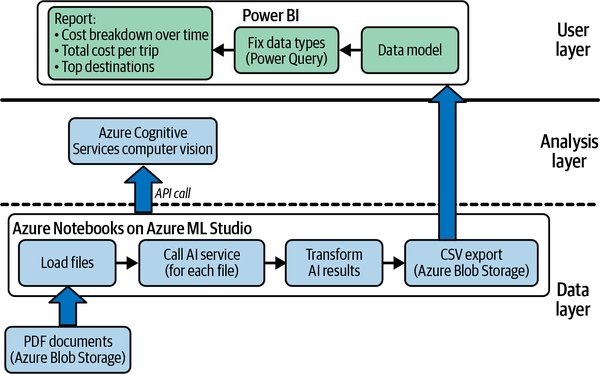

##3. Preparations


### 3.1 Setup & Custom Variables

In [ ]:
# Enter your Azure Cognitive Services Text Analytics Key and Endpoint here:
KEY = "xxxxxxxxxxxxx"
ENDPOINT = "https://xxxxxxxxxxxxxxxxxxx.cognitiveservices.azure.com/"

# Data Filepath
FILES = "pdfs" 

### 3.2 Packages

In [ ]:
# Import packages and load custom functions
%pip install azure-cognitiveservices-vision-computervision

import pandas as pd
import os
import time
import numpy as np
from datetime import datetime

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes

###3.3 Getting Data

In [ ]:
!wget https://aipoweredbi.blob.core.windows.net/public/pdfs.zip

In [ ]:
!unzip pdfs.zip

In [ ]:
files = os.listdir(FILES)

# DEMO FILE
files.sort()
files = files[:1] # limit first for demo
#files = files[:5] # limit top 5 for demo

files

##4. Call AI Service

###4.1 Function definition

In [ ]:
## Authenticate client
computervision_client = ComputerVisionClient(ENDPOINT, CognitiveServicesCredentials(KEY))


# Computer Visison function
def document_analysis(filepath, computervision_client):
  """
  Reads a document using Computer Vision and returns the Read_Result object.

  Parameters
  ----------
  filepath : str
      The filepath to a pdf or image file.
  computervision_client : obj
      Authenticated computer vision client.

  Returns
  -------
  obj
      read_result
  """

  # Open binary file
  file = open(filepath, "rb")

  # Call the POST API that performs image analysis
  read_response = computervision_client.read_in_stream(file, raw=True)

  # Close file
  file.close()

  # Get the operation location (URL with ID at the end) from the response
  read_operation_location = read_response.headers["Operation-Location"]
  
  # Get the ID from the URL
  operation_id = read_operation_location.split("/")[-1]

  # Call the "GET" API and to retrieve the results, wait until they are ready. 
  while True:
      time.sleep(2)
      read_result = computervision_client.get_read_result(operation_id)
      if read_result.status not in ['notStarted', 'running']:
          break 

  # Return the read_result object
  return(read_result)

###4.2 Send data to API

In [ ]:
# Send files to the API one by one and collect results in a list
results = []
for file in files:
  filepath = FILES + "/" + file
  results.append(document_analysis(filepath, computervision_client))
  time.sleep(6) # To not exceed free tier limit of 20 calls per minute

###4.3 Inspect response

In [ ]:
# Inspect the first result
read_result = results[0]
# Print the detected text, line by line
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(line.text)
            print(line.bounding_box)

For reference, this is how the ticket looks like and the information we are looking for:

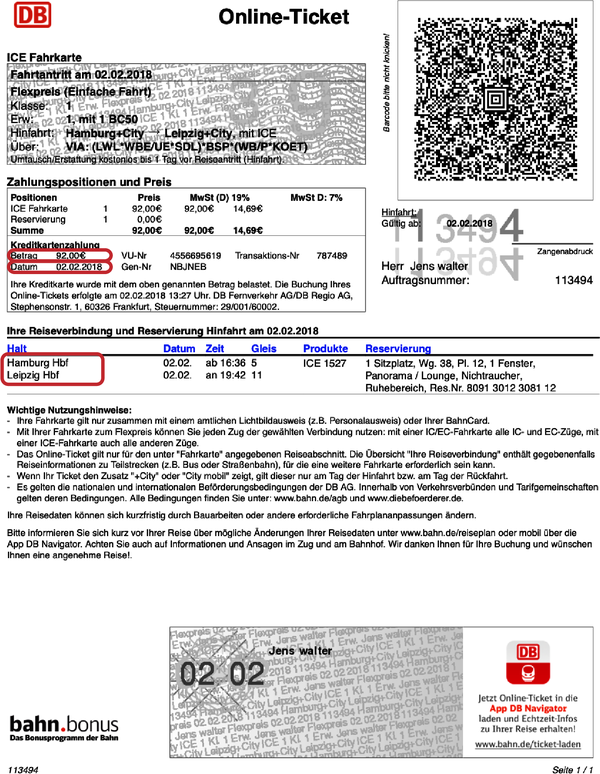

Each item of text is indicated by a bounding box.

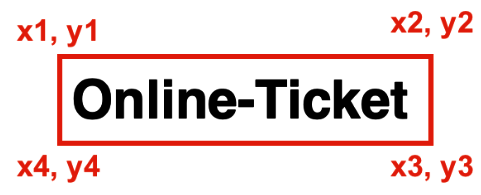

## 5. Transform Response

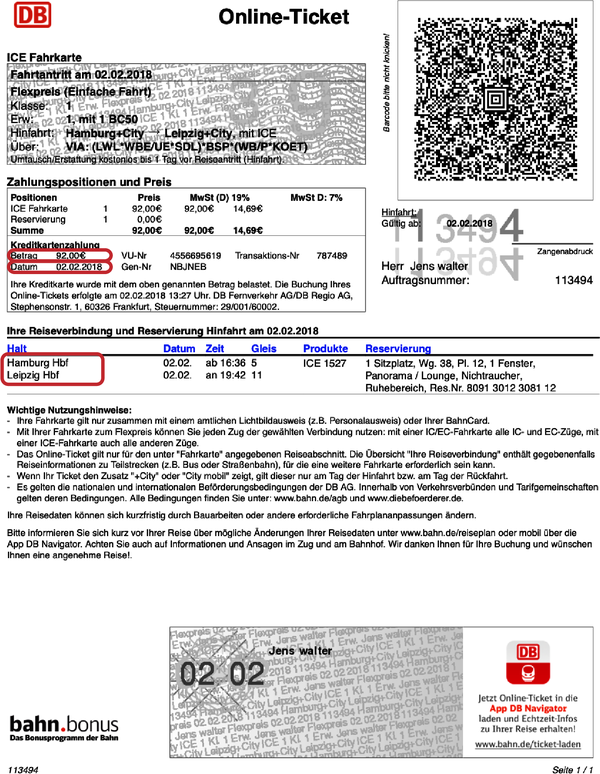

###5.1 Extract Dates by keyword

In [ ]:
# Extract text based after keywords                
def get_text_by_keyword(read_result, keyword, n = 1):
  """
  Returns n items after a string has been found in a list of strings.
  This approach is preferred if the target value has a distinct marker, such as a form label

  Parameters
  ----------
  read_result : obj
      the read_result object from the computer vision API
  keyword : str
      The string that should be found.
  n : the number of subsequent list items that should be returned

  Returns
  -------
  list

  """
  lst = []
  if read_result.status == OperationStatusCodes.succeeded:
      for text_result in read_result.analyze_result.read_results:
          for line in text_result.lines:
            lst.append(line.text)

  for index, elem in enumerate(lst):
      if (index+n < len(lst)): # Ensure we are stay in list bounds
          if elem == keyword:
            return(lst[index+1:index+1+n])
             # stops at the first result

In [ ]:
# Target format
# Table columns: Date, Origin, Destination, Costs, Filename

# Part 1: Extract Dates using keyword in document

dates = []
for result in results:
  dates.append(get_text_by_keyword(result, "Datum"))

# Flatten list
dates = [d[0] for d in dates]

# Convert to international date format
dates = [datetime.strptime(d, '%d.%m.%Y').strftime("%Y-%m-%d") for d in dates]
dates

### 5.2 Extract train stops by keywords and positional arguments

Step 1: Get text text corpus based on keywords

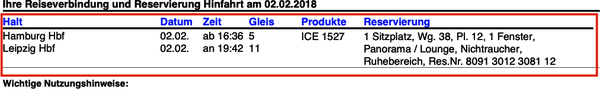

In [ ]:
# Extract text between two keywords               
def get_text_between_keywords(read_result, start_keyword, stop_keyword):
  """
  Returns all items between two keywords in a document

  Parameters
  ----------
  read_result : obj
      the read_result object from the computer vision API
  start_keyword : str
      The string that should start the extraction (inclusive).
  stop_keyword : str
      The string that should stop the extraction (exclusive).

  Returns
  -------
  list

  """
  lst = []
  boxes = []
  if read_result.status == OperationStatusCodes.succeeded:
      for text_result in read_result.analyze_result.read_results:
          for line in text_result.lines:
            lst.append(line.text)
            boxes.append(line.bounding_box)
  
  # Find the index for the start keyword
  for index, elem in enumerate(lst):      
    if elem == start_keyword:
      start_index = index
      break # stops at the first result

  # Find the index for the stop keyword
  for index, elem in enumerate(lst):      
    if elem == stop_keyword:
      stop_index = index
      break # stops at the first result

  # Return only items between start and stop index
  lst = lst[start_index:stop_index]
  boxes = boxes[start_index:stop_index]
  output = [lst, boxes]
  return(output)

In [ ]:
for result in results:
  # Perform text search by keywords
  text_section = get_text_between_keywords(result, "Halt", "Wichtige Nutzungshinweise:")

In [ ]:
text_section

Step 2: Get train stops by position within the selected text corpus

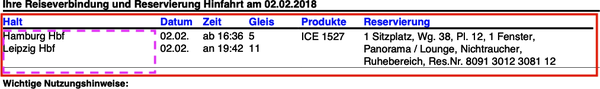

In [ ]:
# Extract text based on position
def get_text_by_position(read_result, filter_box):
  """
  Locates some text inside a read_result object based on a bounding box.
  This approach is preferred if the position of a target text is known in the document

  Parameters
  ----------
  filter_box : list
      List: [x1, y1, x2, y2, x3, y3, x4, y4]
      The (x1, y1) position is at the top left corner,
      the (x3, y3) position is at the bottom right corner
  read_result : obj
      the read_result object from the computer vision API

  Returns
  -------
  list

  """
  lst = []
  if read_result.status == OperationStatusCodes.succeeded:
      for text_result in read_result.analyze_result.read_results:
          for line in text_result.lines:
              target_box = np.array(line.bounding_box)
              if (filter_box[0] <= target_box[0] and filter_box[1] <= target_box[1] and filter_box[4] >= target_box[4] and filter_box[5] >= target_box[5] ):
                lst.append(line.text)
  return(lst)

In [ ]:
# Part 2: Extract From/To using keywords and positional arguments

routes = []
for result in results:
  # Perform text search by keywords
  text_section = get_text_between_keywords(result, "Halt", "Wichtige Nutzungshinweise:")

  # The lower left corner (x4, y4) from "Halt" become upper left corner for the filter (x1, y1)
  for index, text in enumerate(text_section[0]):
    if text == "Halt":
      x1, y1 = text_section[1][index][-2], text_section[1][index][-1]

  # The lower left corner (x4, y4) from "Datum" becomes upper right corner for the filter (x2, y2)
  for index, text in enumerate(text_section[0]):
    if text == "Datum":
      x2, y2 = text_section[1][index][-2], text_section[1][index][-1]

  # For the lower boundaries we take the min and max value of the array
  x4, y4 = min([e[0] for e in text_section[1]]), max([e[5] for e in text_section[1]])

  # Complete x3 and y3
  x3 = x2
  y3 = y4

  # Create the filter 
  filter_box = np.array([x1, y1, x2, y2, x3, y3, x4, y4])
  
  # Apply the filter
  route = get_text_by_position(result, filter_box)

  # We're actually just interested in the origin and final desitination, so let's skip the rest
  route = [route[0], route[-1]]
  routes.append(route)

origins = [e[0] for e in routes]
destinations = [e[1] for e in routes]

origins, destinations

###5.3 Get ticket price by keyword

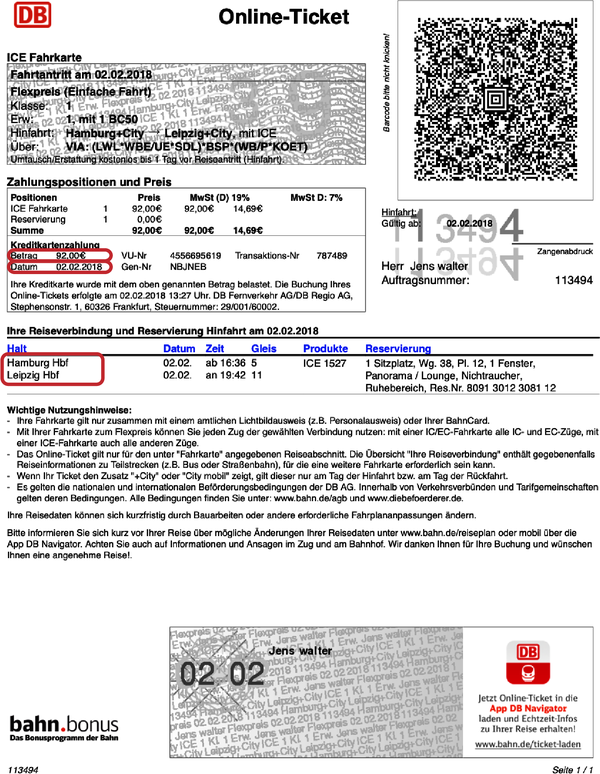

In [ ]:
# Part 3: Extract Price using keywords

prices = []
for result in results:
  # We will extract the following two fields after the keyword and filter based on the € Symbol
  prices.append(get_text_by_keyword(result, "Betrag", 2))

# Flatten list
# Extract the actual currency values from the lists
prices = [[j for j in i if "€" in j] for i in prices]

# Get rid of the "€"  sign
prices = [i[0].replace("€", "") for i in prices]

# Convert str to float
prices = [float(i.replace(",",".")) for i in prices]
prices

Our final data

In [ ]:
print(dates,
origins,
destinations,
prices,
files)

##6. Export flat table

In [ ]:
# Create the final data frame for CSV export
output_df = pd.DataFrame({"Date": dates, "Origin": origins, "Destination": destinations, "Cost": prices, "Receipt": files })
output_df.to_csv("public-transportation-costs.csv", index = False)
output_df

##7. Visualization in Power BI (Example)

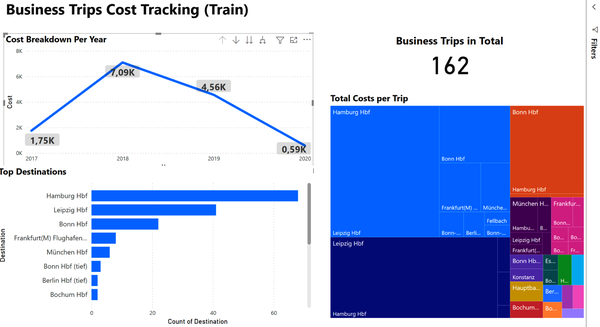